In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE




personal_id
A    130
B    130
C    130
D    130
F    130
E    130
Name: count, dtype: int64


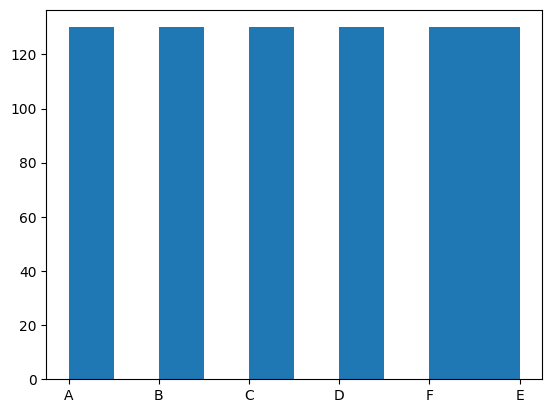

In [18]:
train_data = pd.read_csv("./dataset/train_Mod.csv")
test_data = pd.read_csv("./dataset/test.csv")

# 外れ値の除去
# 外れ値を削除
train_data = train_data[train_data['knee_depth'] < 17.5]
train_data = train_data[train_data['jump_height'] < 80]

# 欠損値を持つ行を削除
train_data = train_data.dropna()

#最初の６列をXとして格納
X = train_data.iloc[:, 1:6]
X_test = train_data.iloc[:, 1:6]
#最後の列をyとして格納
y = train_data.iloc[:, -1]

sm = SMOTE(random_state=42)
X, y = sm.fit_resample(X, y)

#各データの分布を確認
plt.hist(y)
print(y.value_counts())


In [19]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

poly = PolynomialFeatures(degree=3, include_bias=False).fit(X_train_scaled)
X_train_poly = poly.transform(X_train_scaled)
X_val_poly = poly.transform(X_val_scaled)
X_test_poly = poly.transform(X_test_scaled)


In [30]:
def result_to_csv(model, file_name):
    test_data = pd.read_csv("./dataset/test.csv")
    test_data = test_data.iloc[:, 1:6]
    test_data_scaled = scaler.transform(test_data)
    test_data_poly = poly.transform(test_data_scaled)
    y_pred_test = model.predict(test_data_poly)
    y_pred_test = pd.DataFrame(y_pred_test)
    #第１列は'id', 第２列は'personal_id'という列名をつける
    y_pred_test.columns = ['personal_id']
    #idは0起算
    y_pred_test['id'] = y_pred_test.index
    y_pred_test = y_pred_test.reindex(columns=['id', 'personal_id'])
    y_pred_test.to_csv(file_name, index=False)

In [20]:
import lightgbm as lgb

param = {
    'learning_rate': [0.01, 0.05, 0.1, 0.3],
    'max_depth': [4, 5, 6, 8],
    'n_estimators': [50, 100, 150, 200]
}

# LightGBMのモデルを作成
lgbm = lgb.LGBMClassifier(objective='multiclass', num_class=6)

# GridSearchCVの設定
grid_search = GridSearchCV(lgbm, param, cv=3, n_jobs=-1)

# ハイパーパラメータ探索
grid_search.fit(X_train_poly, y_train)

# 最適なパラメータとその時のスコアを表示
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")

# 最適なパラメータでモデルを訓練
best_lgbm = grid_search.best_estimator_

# テストデータで評価
y_pred = best_lgbm.predict(X_val_poly)
accuracy = accuracy_score(y_val, y_pred)
print(f"Valid accuracy: {accuracy}")

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010904 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11440
[LightGBM] [Info] Number of data points in the train set: 624, number of used features: 55
[LightGBM] [Info] Start training from score -1.801421
[LightGBM] [Info] Start training from score -1.782190
[LightGBM] [Info] Start training from score -1.782190
[LightGBM] [Info] Start training from score -1.821030
[LightGBM] [Info] Start training from score -1.811178
[LightGBM] [Info] Start training from score -1.754019
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

In [21]:
#ランダムフォレスト
from sklearn.ensemble import RandomForestClassifier

# パイプラインの作成
pipe = Pipeline([
    ('random_forest', RandomForestClassifier())
])

# グリッドサーチのパラメータ
param_grid = {
    'random_forest__n_estimators': [10, 50, 100],  # 木の数
    'random_forest__max_depth': [None, 10, 20, 30],     # 木の最大深さ
    'random_forest__min_samples_split': [5, 10, 20],     # 内部ノードを分割するための最小サンプル数
    'random_forest__min_samples_leaf': [1, 2, 4],       # 葉ノードに必要な最小サンプル数
    'random_forest__max_features': ['sqrt'],    # 最適な分割を探す際に考慮する特徴量の数
}

# GridSearchCVの設定
random_forest = GridSearchCV(pipe, param_grid, cv=3, scoring='accuracy', n_jobs=-1)

# グリッドサーチの実行
random_forest.fit(X_train_poly, y_train)

# 最適なパラメータとその時のスコアを表示
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")

# 最適なパラメータでモデルを訓練
best_rf = grid_search.best_estimator_

# テストデータで評価
y_pred = best_rf.predict(X_val_poly)
accuracy = accuracy_score(y_val, y_pred)
print(f"Valid accuracy: {accuracy}")

Best parameters: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100}
Best score: 0.8189102564102564
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Valid accuracy: 0.7948717948717948


In [34]:
#ロジスティック回帰
from sklearn.linear_model import LogisticRegression

# チューニングしたいハイパーパラメータの範囲
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100, 1024],
    'penalty': ['l1', 'l2']
}

# モデルのインスタンス化
lr = LogisticRegression(multi_class='multinomial', max_iter=5000)

# GridSearchCVの設定
grid_search = GridSearchCV(lr, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# モデルの訓練
grid_search.fit(X_train_poly, y_train)

# 最良のハイパーパラメータを表示
print("Best parameters: ", grid_search.best_params_)

# モデルの評価
y_pred = grid_search.predict(X_val_poly)
print("Valid accuracy_score: ", accuracy_score(y_val, y_pred))

best_logistic = grid_search.best_estimator_


c:\Users\syu\Learning\Rikkyo-OpenHouseComp\.venv\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
30 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\syu\Learning\Rikkyo-OpenHouseComp\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\syu\Learning\Rikkyo-OpenHouseComp\.venv\lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\syu\Learning\Rikkyo-OpenHouseComp\.venv\lib\site-packages\sklearn\linear_model\_

Best parameters:  {'C': 1024, 'penalty': 'l2'}
Valid accuracy_score:  0.8205128205128205


In [35]:
result_to_csv(best_logistic, "submit_logistic.csv")

In [36]:
from sklearn.ensemble import VotingClassifier
# チューニングしたいハイパーパラメータの範囲
param_grid = {
    'logi__C': [0.01, 0.1, 1, 10, 100],
    'logi__penalty': ['l1', 'l2'],
    'lgb__n_estimators': [50, 100, 200],
    'lgb__learning_rate': [0.01, 0.1, 1],
    'lgb__num_leaves': [31, 62, 124],
    'rf__random_forest__max_depth': [None, 10, 20, 30],
    'rf__random_forest__n_estimators': [10, 50, 100],
    'rf__random_forest__max_features': ['sqrt'],
    'voting': ['hard', 'soft']
}


# GridSearchCVの設定
# アンサンブルモデルの設定（Voting Classifier）
ensemble_model = VotingClassifier(estimators=[('logi', best_logistic),('lgb', best_lgbm), ('rf', best_rf)], voting='soft')
grid_search = GridSearchCV(ensemble_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# モデルの訓練
grid_search.fit(X_train_poly, y_train)

# 最良のハイパーパラメータを表示
print("Best parameters: ", grid_search.best_params_)

# モデルの評価
y_pred = grid_search.predict(X_val_poly)
print("Valid accuracy_score: ", accuracy_score(y_val, y_pred))

KeyboardInterrupt: 

In [31]:
#CSV 
result_to_csv(grid_search, "submit_ensemble.csv")
result_to_csv(best_rf, "submit_rf.csv")
result_to_csv(best_lgbm, "submit_lgbm.csv")


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
